In [1]:
import re


class ModuleDescription:
    def __init__(self, module_description_string):
        self.module_description_string = module_description_string
        (
            self.parsed_module,
            self.is_single_step,
        ) = ModuleDescriptionParser().parse_module_string(module_description_string)
        if isinstance(self.parsed_module, ModuleDescriptionOrRelation):
            new_and = ModuleDescriptionAndRelation()
            new_and.relations = [self.parsed_module]
            self.parsed_module = new_and

    def kos(self):
        """Return an iterable over the total list of KOs in the module"""
        r_kegg = re.compile("K\d{5}")
        if any(r_kegg.findall(self.module_description_string)):
            return r_kegg.findall(self.module_description_string)

    def num_steps(self):
        if isinstance(self.parsed_module, ModuleDescriptionAndRelation):
            return len(self.parsed_module.relations)
        else:
            raise Exception("Cannot work with non-AND type modules")

    def num_covered_steps(self, ko_set):
        if not isinstance(self.parsed_module, ModuleDescriptionAndRelation):
            raise Exception("Cannot work with non-AND type modules")
        step_cov = 0
        path_cov = 0
        reac_cov = 0
        ko_path = {}
        for idx, m in enumerate(self.parsed_module.relations):
            step_passed, step_counts, reaction_counts, ko = m.satisfied_with(ko_set, [])
            if step_passed:
                step_cov += 1
                path_cov += step_counts
                ko_path[idx] = ko
            reac_cov += reaction_counts
        return step_cov, path_cov, reac_cov, ko_path


class GetLowestRelation:
    @staticmethod
    def get_lowest_relation(input_relation, to_fill):
        if type(input_relation) == ModuleDescriptionKoEntry:
            to_fill.append(input_relation.ko)
        else:
            for relation in input_relation.relations:
                if type(relation) == ModuleDescriptionKoEntry:
                    to_fill.append(relation.ko)
                else:
                    GetLowestRelation.get_lowest_relation(relation, to_fill)
        return to_fill


class ModuleDescriptionAndRelation:
    def satisfied_with(self, set_of_kos, kos):
        counts = 0
        step_passed = False
        reaction_counts = 0
        founds = []
        for r in self.relations:
            found, count, reaction_count, ko = r.satisfied_with(set_of_kos, kos)
            if found:
                founds.append(1)
                counts += count
                for k in ko:
                    if k not in kos:
                        kos.append(k)
            reaction_counts += reaction_count
        step_passed = len(self.relations) == sum(founds)
        return step_passed, counts, reaction_counts, kos


class ModuleDescriptionPlusRelation(ModuleDescriptionAndRelation):
    pass


class ModuleDescriptionOrRelation:
    def satisfied_with(self, set_of_kos, kos):
        counts = 0
        step_passed = False
        reaction_counts = 0
        for r in self.relations:
            found, _, reaction_count, ko = r.satisfied_with(set_of_kos, kos)
            if found:
                step_passed = True
                for k in ko:
                    if k not in kos:
                        kos.append(k)
            else:
                kos_to_extract = GetLowestRelation.get_lowest_relation(r, [])
                for ko in kos_to_extract:
                    if ko in kos:
                        kos.remove(ko)
            reaction_counts += reaction_count
        return step_passed, counts, reaction_counts, kos


class ModuleDescriptionKoEntry:
    def __init__(self, ko):
        self.ko = ko

    def satisfied_with(self, set_of_kos, kos):
        found = self.ko in set_of_kos
        count = 1 if found else 0
        reaction_count = 1
        return found, count, reaction_count, [self.ko]


class ParserHelper:
    pass


class ModuleDescriptionParser:
    def correct_substrings(self, substring_list):
        fixed_substrings = []
        for substring in substring_list:
            # Omit optional enzyme (e.g. M00372)
            # or undefined KO group (e.g. M00079)
            if substring.startswith("-"):
                continue
            # Remove redundant and definitions
            substring = substring.replace(", ", ",")
            fixed_substrings.append(substring)
        return fixed_substrings

    def parse_module_string(self, string):
        frags1 = self.split_on_space(string)
        frags1 = self.correct_substrings(frags1)
        is_single_step = len(frags1) == 1
        if is_single_step:
            if len(self.split_on_comma(frags1[0])) > 1:
                frags1 = self.split_on_comma(frags1[0])
                master_relation = ModuleDescriptionOrRelation()
            elif len(self.split_on_plus(frags1[0])) > 1:
                frags1 = self.split_on_plus(frags1[0])
                master_relation = ModuleDescriptionAndRelation()
            else:
                frags1 = self.split_on_comma(frags1[0])
                master_relation = ModuleDescriptionOrRelation()
        else:
            master_relation = ModuleDescriptionAndRelation()
        current = ParserHelper()
        current.top_relation = master_relation
        current.understuff = frags1
        stack = [current]
        while len(stack) > 0:
            current = stack.pop()
            new_stuff = []
            for e in current.understuff:
                if isinstance(e, str):
                    if " " not in e and "," not in e and "+" not in e and "-" not in e:
                        new_stuff.append(ModuleDescriptionKoEntry(e))
                    else:
                        frags = self.split_on_comma(e)
                        if len(frags) == 1:
                            topush = ParserHelper()
                            comma_splits = self.split_on_space(e)
                            m = None
                            if len(comma_splits) == 1:
                                plus_splits = self.split_on_plus(e)
                                minus_splits = self.split_on_minus(e)
                                if len(plus_splits) > 1:
                                    m = ModuleDescriptionPlusRelation()
                                    topush.understuff = plus_splits
                                elif len(minus_splits) > 1:
                                    m = ModuleDescriptionAndRelation()
                                    topush.understuff = minus_splits[:1]
                                else:
                                    raise Exception(f"Parse exception on {string}")
                            else:
                                m = ModuleDescriptionAndRelation()
                                topush.understuff = comma_splits
                            topush.top_relation = m
                        else:
                            m = ModuleDescriptionOrRelation()
                            topush = ParserHelper()
                            topush.top_relation = m
                            topush.understuff = frags
                        stack.append(topush)
                        new_stuff.append(m)
                else:
                    new_stuff.append(e)
            current.top_relation.relations = new_stuff
        return master_relation, is_single_step

    def split_on(self, string, characters):
        bracket_counter = 0
        fragments = []
        current = []
        remove_end_brackets = True
        for i in range(len(string)):
            c = string[i]
            if c == "(":
                current += c
                bracket_counter += 1
            elif c == ")":
                current += c
                bracket_counter -= 1
                if bracket_counter == 0 and i < len(string) - 1:
                    remove_end_brackets = False
            elif c in characters and bracket_counter == 0:
                fragments.append("".join(current))
                current = ""
            else:
                current += c
        fragments.append("".join(current))
        if remove_end_brackets and string[0] == "(":
            if string[-1] != ")":
                raise Exception("Parse error")
            return self.split_on(string[1:-1], characters)
        return fragments

    def split_on_space(self, string):
        return self.split_on(string, " ")

    def split_on_plus(self, string):
        return self.split_on(string, "+")

    def split_on_comma(self, string):
        return self.split_on(string, ",")

    def split_on_minus(self, string):
        return self.split_on(string, "-")


In [2]:
module_description_dict = {}
with open("definitions.tsv") as fin:
    for line in fin:
        accession, module_description = line.strip().split("\t")
        module_description_dict[accession] = ModuleDescription(module_description)

In [3]:
def is_present(annotations, path, min_cov=0.7, required=set()):
    num_covered, _, _, ko_path = path.num_covered_steps(annotations)
    num_all = path.num_steps()
    frac_covered = num_covered / num_all
    return frac_covered >= min_cov and required.issubset(annotations)

path = module_description_dict["M00356"]
annotations = ["K14080", "K04480", "K14081", "K08264", "K08265"]
is_present(annotations, path)

False

In [37]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [53]:
aggregated_table = pd.read_csv("../aggregated_tables/dereplicated_aggregated_table.tsv", sep="\t")

In [6]:
def is_present(annotations, path, min_cov=0.7, min_cov_two_steps=0.5, required=set()):
    num_covered, _, _, ko_path = path.num_covered_steps(annotations)
    num_all = path.num_steps()
    frac_covered = num_covered / num_all
    if num_all == 2:
        return frac_covered >= min_cov_two_steps and required.issubset(annotations)
    else:
        return frac_covered >= min_cov and required.issubset(annotations)

In [54]:
selected_modules = {"M00567", "M00357", "M00356", "M00563", "M00174", "M00528"}
heatmap_data = aggregated_table.loc[[i in selected_modules for i in aggregated_table.module]].groupby(
    "module"
    ).sum().loc[:, [
    "RPKG_ERR7569997",
    "RPKG_ERR7569998",
    "RPKG_ERR7569999",
    "RPKG_ERR7570000",
    "RPKG_ERR7570001",
    "RPKG_ERR7570002",
    "RPKG_ERR7570003",
    "RPKG_ERR7570004",
    "RPKG_ERR7570005",
    "RPKG_ERR7570006",
]]
heatmap_data = heatmap_data.reindex(["M00567", "M00357", "M00356", "M00563", "M00174", "M00528"])
heatmap_data = np.log(heatmap_data + 1)
heatmap_data = (heatmap_data - heatmap_data.mean(1).values.reshape(-1,1)) / heatmap_data.std(1).values.reshape(-1,1)

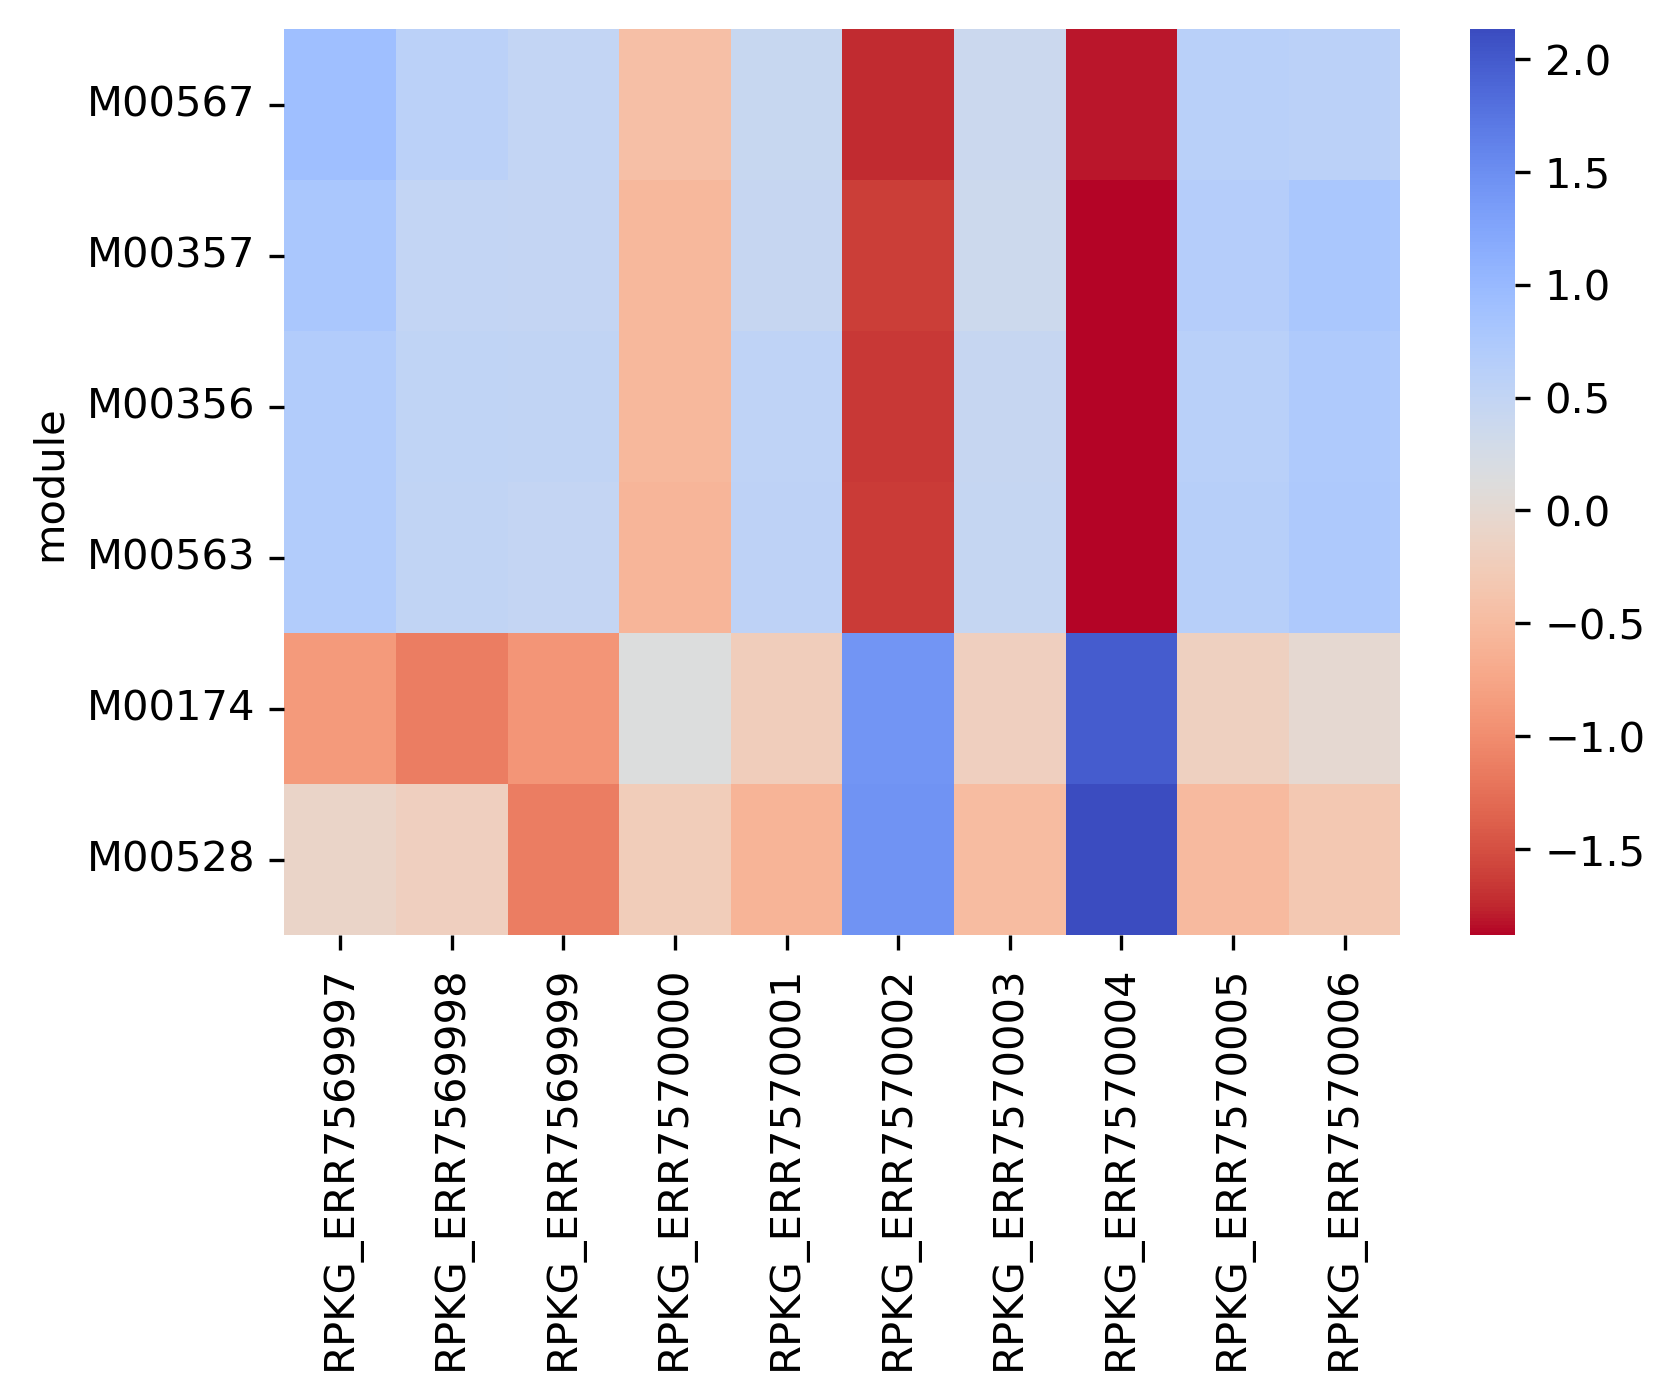

In [55]:
fig, ax = plt.subplots(dpi = 300)
sns.heatmap(heatmap_data, cmap="coolwarm_r")
fig.savefig("heatmap.pdf")

In [97]:
selected_modules = {"M00567", "M00357", "M00356", "M00563"}
selected_ko = set(aggregated_table.loc[[i in selected_modules for i in aggregated_table.module]].assign(
    avg_rpkg = lambda x: x[[
    "RPKG_ERR7569997",
    "RPKG_ERR7569998",
    "RPKG_ERR7569999",
    "RPKG_ERR7570000",
    "RPKG_ERR7570001",
    "RPKG_ERR7570002",
    "RPKG_ERR7570003",
    "RPKG_ERR7570004",
    "RPKG_ERR7570005",
    "RPKG_ERR7570006",
    ]].mean(axis=1)
    ).query("superkingdom == 'Bacteria'").ko.values)
for module in ["M00356", "M00357", "M00563", "M00567"]:
    path = module_description_dict[module]
    for module in ["M00356", "M00357", "M00563", "M00567"]:
        path = module_description_dict[module]
        module_present = is_present(selected_ko, path)
    print(module, module_present)

M00567 False
M00567 False
M00567 False
M00567 False


In [101]:
selected_modules = {"M00528"}
aggregated_table.loc[[i in selected_modules for i in aggregated_table.module]].loc[:, [
    "family",
    "RPKG_ERR7569997",
    "RPKG_ERR7569998",
    "RPKG_ERR7569999",
    "RPKG_ERR7570000",
    "RPKG_ERR7570001",
    "RPKG_ERR7570002",
    "RPKG_ERR7570003",
    "RPKG_ERR7570004",
    "RPKG_ERR7570005",
    "RPKG_ERR7570006",
    ]].assign(
    avg_rpkg = lambda x: x[[
    "RPKG_ERR7569997",
    "RPKG_ERR7569998",
    "RPKG_ERR7569999",
    "RPKG_ERR7570000",
    "RPKG_ERR7570001",
    "RPKG_ERR7570002",
    "RPKG_ERR7570003",
    "RPKG_ERR7570004",
    "RPKG_ERR7570005",
    "RPKG_ERR7570006",
    ]].mean(axis=1)
    ).groupby("family", dropna=False).sum().sort_values(by="avg_rpkg",ascending=False).head(10)

,RPKG_ERR7569997,RPKG_ERR7569998,RPKG_ERR7569999,RPKG_ERR7570000,RPKG_ERR7570001,RPKG_ERR7570002,RPKG_ERR7570003,RPKG_ERR7570004,RPKG_ERR7570005,RPKG_ERR7570006,avg_rpkg
family,,,,,,,,,,,
NaN,1.049321,0.987265,0.499624,0.922047,0.690617,1.595921,0.791168,1.933895,0.842676,0.973692,1.028623
Nitrospiraceae,0.000000,0.001739,0.040119,0.124418,0.166098,0.671283,0.138662,0.928757,0.079907,0.094893,0.224588
Syntrophaceae,0.152202,0.116114,0.132180,0.044821,0.059556,0.005023,0.053217,0.000643,0.034744,0.003056,0.060156
Nitrosomonadaceae,0.000000,0.000000,0.003911,0.019301,0.018455,0.031975,0.008901,0.078281,0.011875,0.011510,0.018421
Pirellulaceae,0.012371,0.058889,0.012298,0.021492,0.004886,0.005422,0.001669,0.002583,0.015029,0.004984,0.013962
Ignavibacteriaceae,0.000000,0.000511,0.001581,0.006201,0.007707,0.020644,0.003173,0.035566,0.005659,0.005655,0.008670


In [152]:
for sample in [
    "RPKG_ERR7569997",
    "RPKG_ERR7569998",
    "RPKG_ERR7569999",
    "RPKG_ERR7570000",
    "RPKG_ERR7570001",
    "RPKG_ERR7570002",
    "RPKG_ERR7570003",
    "RPKG_ERR7570004",
    "RPKG_ERR7570005",
    "RPKG_ERR7570006",
    ]:
    selected_ko = set(aggregated_table.groupby(
        ["superkingdom", "ko"], dropna=False
    ).apply(
        lambda x: pd.Series({"RPKG": x[sample].sum()})
    ).reset_index().query(
        "RPKG >= 0.5"
    ).ko.values)
    for module in ["M00356", "M00357", "M00563", "M00567", "M00174", "M00528"]:
        path = module_description_dict[module]
        if module == "M00356":
            module_present = is_present(selected_ko, path, required={"K14080"})
        elif module == "M00357":
            module_present = is_present(selected_ko, path, required={"K00925"})
        elif module == "M00563":
            module_present = is_present(selected_ko, path, required={"K14082"})
        elif module == "M00567":
            module_present = is_present(selected_ko, path, required={"K00200", "K00672", "K00672"})
        else:
            module_present = is_present(selected_ko, path)
        print(sample, module, module_present)
    print("----------------------------")

RPKG_ERR7569997 M00356 False
RPKG_ERR7569997 M00357 True
RPKG_ERR7569997 M00563 False
RPKG_ERR7569997 M00567 True
RPKG_ERR7569997 M00174 False
RPKG_ERR7569997 M00528 True
----------------------------
RPKG_ERR7569998 M00356 False
RPKG_ERR7569998 M00357 True
RPKG_ERR7569998 M00563 False
RPKG_ERR7569998 M00567 True
RPKG_ERR7569998 M00174 False
RPKG_ERR7569998 M00528 True
----------------------------
RPKG_ERR7569999 M00356 False
RPKG_ERR7569999 M00357 True
RPKG_ERR7569999 M00563 False
RPKG_ERR7569999 M00567 True
RPKG_ERR7569999 M00174 False
RPKG_ERR7569999 M00528 True
----------------------------
RPKG_ERR7570000 M00356 False
RPKG_ERR7570000 M00357 True
RPKG_ERR7570000 M00563 False
RPKG_ERR7570000 M00567 True
RPKG_ERR7570000 M00174 False
RPKG_ERR7570000 M00528 True
----------------------------
RPKG_ERR7570001 M00356 False
RPKG_ERR7570001 M00357 True
RPKG_ERR7570001 M00563 False
RPKG_ERR7570001 M00567 True
RPKG_ERR7570001 M00174 False
RPKG_ERR7570001 M00528 True
----------------------------
